In [4]:
import numpy as np
import pandas as pd

np.random.seed(23)

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20)

df = pd.DataFrame(class1_sample,columns=['feature1','feature2','feature3'])
df['target'] = 1

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20)

df1 = pd.DataFrame(class2_sample,columns=['feature1','feature2','feature3'])

df1['target'] = 0

df=pd.concat([df, df1], ignore_index=True)

df = df.sample(40)

In [5]:
df.head()

,feature1,feature2,feature3,target
2,-0.367548,-1.137460,-1.322148,1
34,0.177061,-0.598109,1.226512,0
14,0.420623,0.411620,-0.071324,1
11,1.968435,-0.547788,-0.679418,1
12,-2.506230,0.146960,0.606195,1


In [6]:
import plotly.express as px
#y_train_trf = y_train.astype(str)
fig = px.scatter_3d(df, x=df['feature1'], y=df['feature2'], z=df['feature3'],
              color=df['target'].astype('str'))
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [7]:
# Step 1 - Apply standard scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df.iloc[:,0:3] = scaler.fit_transform(df.iloc[:,0:3])

In [8]:
# Step 2 - Find Covariance Matrix
covariance_matrix = np.cov([df.iloc[:,0],df.iloc[:,1],df.iloc[:,2]])
print('Covariance Matrix:\n', covariance_matrix)

Covariance Matrix:
 [[1.02564103 0.20478114 0.080118  ]
 [0.20478114 1.02564103 0.19838882]
 [0.080118   0.19838882 1.02564103]]


In [9]:
# Step 3 - Finding EV and EVs
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

In [10]:
eigen_values

array([1.3536065 , 0.94557084, 0.77774573])

In [11]:
eigen_vectors

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442],
       [-0.52848211,  0.72025103,  0.44938304]])

Populating the interactive namespace from numpy and matplotlib


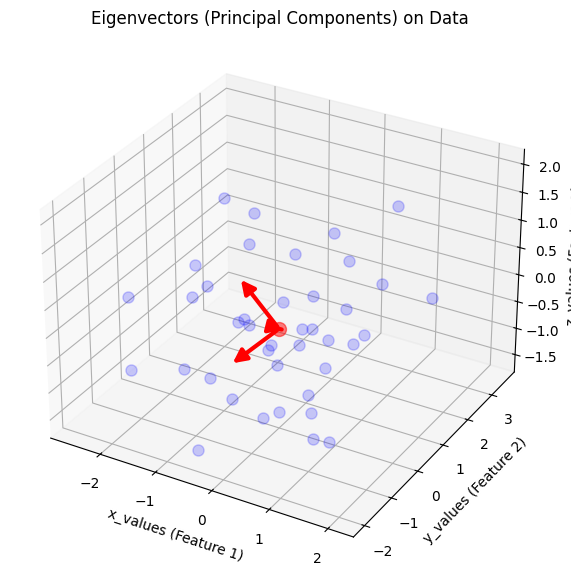

In [14]:
%pylab inline
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

# --- 1. PCA CALCULATION ---
# This block defines the 'eigen_vectors' variable needed for the plotting loop.

# 1.1. Prepare Data (Select features and Center around the mean)
features = ['feature1', 'feature2', 'feature3']
X = df[features].values
mean_vec = np.mean(X, axis=0) # Mean of each feature
X_standardized = X - mean_vec

# 1.2. Calculate Covariance Matrix
cov_mat = np.cov(X_standardized.T)

# 1.3. Calculate Eigenvalues and Eigenvectors
eigen_vals, eigen_vectors = np.linalg.eig(cov_mat)

# Sort eigenvectors by their corresponding eigenvalues (largest first)
eigen_vectors = eigen_vectors.T[np.argsort(eigen_vals)[::-1]].T


# --- 2. CORRECTED 3D ARROW CLASS ---
# This class is fixed by adding the required 'do_3d_projection' method.
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    # FIX: Add do_3d_projection for 3D depth sorting
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        # Use self.axes.M for the projection matrix
        _, _, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        return min(zs)

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        # Use self.axes.M for the projection matrix
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


# --- 3. PLOTTING ---
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 40 data points
ax.plot(df['feature1'], df['feature2'], df['feature3'], 'o', markersize=8, color='blue', alpha=0.2)

# Plot the mean vector (center point of the data)
# Note: df['featureX'].mean() is used as the center point
ax.plot([df['feature1'].mean()], [df['feature2'].mean()], [df['feature3'].mean()], 'o', markersize=10, color='red', alpha=0.5)

# Plot the Eigenvectors (Principal Components) starting from the mean
for v in eigen_vectors.T:
    # Arrow starts at the mean and extends in the eigenvector direction
    start_point = [df['feature1'].mean(), df['feature2'].mean(), df['feature3'].mean()]
    end_point = [start_point[0] + v[0], start_point[1] + v[1], start_point[2] + v[2]]

    a = Arrow3D([start_point[0], end_point[0]],
                [start_point[1], end_point[1]],
                [start_point[2], end_point[2]],
                mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)

ax.set_xlabel('x_values (Feature 1)')
ax.set_ylabel('y_values (Feature 2)')
ax.set_zlabel('z_values (Feature 3)')

plt.title('Eigenvectors (Principal Components) on Data')

plt.show()

In [15]:
pc = eigen_vectors[0:2]
pc

array([[-0.53875915, -0.69363291,  0.47813384],
       [-0.65608325, -0.01057596, -0.75461442]])

In [16]:
transformed_df = np.dot(df.iloc[:,0:3],pc.T)
# 40,3 - 3,2
new_df = pd.DataFrame(transformed_df,columns=['PC1','PC2'])
new_df['target'] = df['target'].values
new_df.head()

,PC1,PC2,target
0,0.599433,1.795862,1
1,1.056919,-0.212737,0
2,-0.271876,0.498222,1
3,-0.621586,0.023110,1
4,1.567286,1.730967,1


In [17]:
new_df['target'] = new_df['target'].astype('str')
fig = px.scatter(x=new_df['PC1'],
                 y=new_df['PC2'],
                 color=new_df['target'],
                 color_discrete_sequence=px.colors.qualitative.G10
                )

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()